In [1]:
!pip install tcav tensorflow matplotlib scikit-learn --quiet

In [2]:
!pip install protobuf==3.20.3

In [3]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tcav.model as model
import tcav.utils as utils
from tcav.tcav import TCAV

In [5]:
base_dir = '/content/drive/MyDrive/tcav_dataset_XAI'  # <- CHANGE THIS to your path
concept_dir = os.path.join(base_dir, 'chequered')
target_dir = os.path.join(base_dir, 'stripped')
bottleneck_name = 'mixed10'  # layer name in InceptionV3
target_class = 'stripped'


In [6]:
def load_images_from_folder(folder, target_size=(299, 299)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = image.load_img(img_path, target_size=target_size)
        img = image.img_to_array(img)
        images.append(preprocess_input(img))
    return np.array(images)

chequered_imgs = load_images_from_folder(concept_dir)
stripped_imgs = load_images_from_folder(target_dir)

print(f'Loaded {len(chequered_imgs)} chequered images')
print(f'Loaded {len(stripped_imgs)} stripped images')

Loaded 114 chequered images
Loaded 114 stripped images


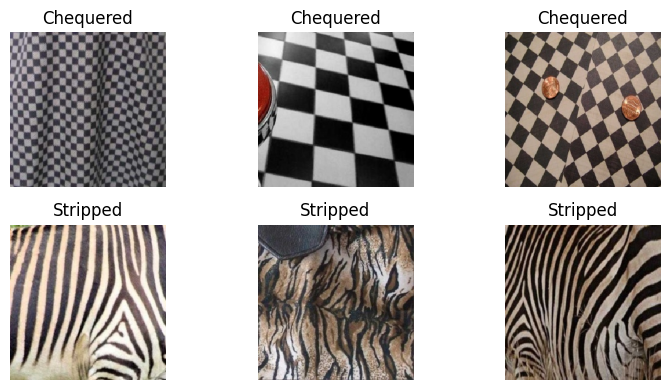

In [7]:
# Show samples
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tf.cast((chequered_imgs[i] + 1) * 127.5, tf.uint8))
    plt.title("Chequered")
    plt.axis("off")

    plt.subplot(2, 3, i+4)
    plt.imshow(tf.cast((stripped_imgs[i] + 1) * 127.5, tf.uint8))
    plt.title("Stripped")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
inception_model = InceptionV3(include_top=True, weights='imagenet')
bottleneck_model = tf.keras.Model(
    inputs=inception_model.input,
    outputs=inception_model.get_layer(bottleneck_name).output
)

In [9]:
def get_activations(model, imgs):
    return model.predict(imgs, verbose=0)

act_chequered = get_activations(bottleneck_model, chequered_imgs)
act_stripped = get_activations(bottleneck_model, stripped_imgs)

print("Activations shape:", act_chequered.shape)

Activations shape: (114, 8, 8, 2048)


In [10]:
X = np.concatenate([act_chequered.reshape(len(act_chequered), -1),
                    act_stripped.reshape(len(act_stripped), -1)])
y = [0]*len(act_chequered) + [1]*len(act_stripped)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
clf = SGDClassifier(max_iter=1000, tol=1e-3).fit(X_train, y_train)

acc = accuracy_score(y_test, clf.predict(X_test))
print(f"CAV classifier accuracy: {acc:.2f}")

CAV classifier accuracy: 0.98


In [22]:
def compute_tcav_score(images, cav, label_idx):
    grads_list = []

    for img in images:
        img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0))
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            bottleneck_output = bottleneck_model(img_tensor)
            preds = inception_model(img_tensor)
            loss = preds[:, label_idx]
        grads = tape.gradient(loss, bottleneck_output)
        grads_list.append(grads.numpy())

    grads_arr = np.array(grads_list)
    dd = directional_derivative(grads_arr, cav)
    return np.mean(dd < 0)

In [23]:
def directional_derivative(gradients, cav):
    flat_grads = gradients.reshape(len(gradients), -1)
    flat_cav = cav.reshape(-1)
    return np.dot(flat_grads, flat_cav)


In [29]:
def compute_tcav_score(images, cav, label_idx):
    grads_list = []

    for img in images:
        img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Watch the input tensor (img_tensor)
            tape.watch(img_tensor)

            # Get bottleneck output and prediction from full model
            bottleneck_output = bottleneck_model(img_tensor)
            preds = inception_model(img_tensor)
            loss = preds[:, label_idx]

        # Get gradients w.r.t. bottleneck layer output
        grads = tape.gradient(loss, bottleneck_output)

        # Raise ValueError if gradient is still None
        if grads is None:
            raise ValueError("Gradient is None. Check if img_tensor is being watched correctly. Ensure all operations between bottleneck_output and loss are differentiable")

        grads_list.append(grads.numpy())

    grads_arr = np.array(grads_list)
    dd = directional_derivative(grads_arr, cav)
    return np.mean(dd < 0)

In [31]:
# Get layer after 'mixed10' (flatten → dense → softmax)
logit_model = tf.keras.Model(
    inputs=bottleneck_model.output,
    outputs=inception_model.output
)

In [32]:
def compute_tcav_score(images, cav, label_idx):
    grads_list = []

    for img in images:
        img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)

        with tf.GradientTape() as tape:
            bottleneck_output = bottleneck_model(img_tensor)
            tape.watch(bottleneck_output)

            logits = logit_model(bottleneck_output)
            loss = logits[:, label_idx]

        grads = tape.gradient(loss, bottleneck_output)

        if grads is None:
            raise ValueError("Gradient is None. Ensure tape is watching bottleneck_output and logit_model is used.")

        grads_list.append(grads.numpy())

    grads_arr = np.array(grads_list)
    dd = directional_derivative(grads_arr, cav)
    return np.mean(dd < 0)


In [33]:
label_index = 834  # Replace with correct label if needed
cav_vec = clf.coef_.reshape(act_chequered.shape[1:])
tcav_score = compute_tcav_score(stripped_imgs, cav_vec, label_index)

print(f"TCAV Score (chequered → stripped): {tcav_score:.2f}")

TCAV Score (chequered → stripped): 0.98


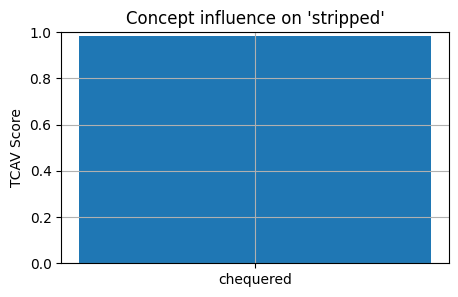

In [34]:
plt.figure(figsize=(5, 3))
plt.bar(["chequered"], [tcav_score])
plt.ylim(0, 1)
plt.ylabel("TCAV Score")
plt.title(f"Concept influence on '{target_class}'")
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

🧠 Model Predictions:
1. cabbage_butterfly (n02280649) - 0.25
2. American_egret (n02009912) - 0.07
3. lacewing (n02264363) - 0.03


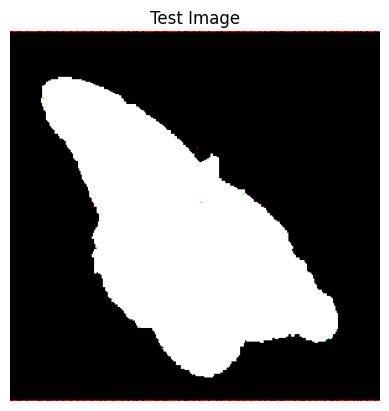

In [39]:
def test_image(img_path):
    img = image.load_img('/content/drive/MyDrive/0010006_seg0.png', target_size=(299, 299))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = inception_model.predict(x)
    decoded = decode_predictions(preds, top=3)[0]

    print("\n🧠 Model Predictions:")
    for i, (code, label, prob) in enumerate(decoded):
        print(f"{i+1}. {label} ({code}) - {prob:.2f}")

    # Moved the plotting code inside the function
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis("off")
    plt.show()

# Call the function to execute it and display the image
test_image('/content/drive/MyDrive/0010006_seg0.png') # Replace with actual path if needed